## Análisis Multivariado de Señales Sismográficas

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

2021


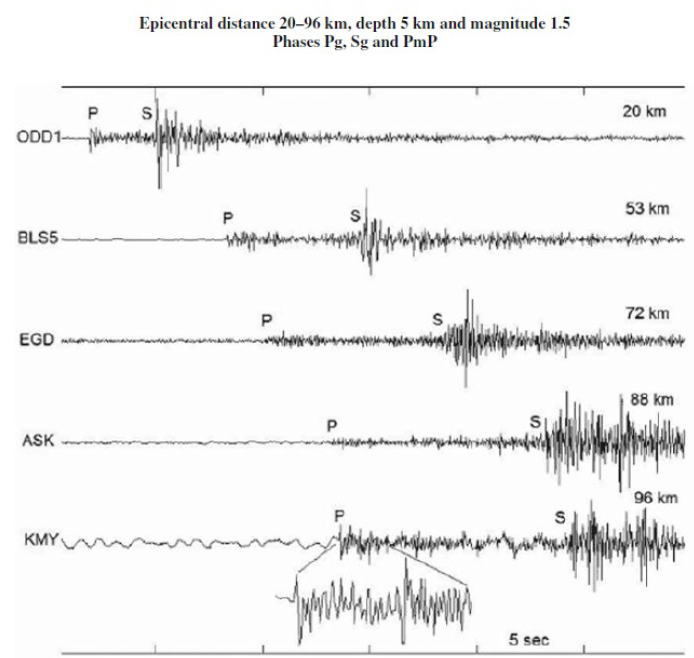

Los observatorios sismológicos clasifican las señales sísmicas de acuerdo a la diferencia de tiempo de arribo entre la onda P y la onda S, conocida como S-P. La S-P, es una indicación de la distancia que existe desde el punto donde se genera el sismo al punto donde se encuentra la estación que lo registra, es decir de la distancia epicentral. Dicho parámetro, aplicado a las señales registradas
por el OSQ permite definir tres tipos de sismos: local, caracterizado por tener una S-P menor a 20 s; regional cuya S-P varía entre 20 s y 180 s y telesismo, cuya S-P es mayor 180 s.

In [1]:
!pip install pyts

     |████████████████████████████████| 2.5MB 16.5MB/s 


In [2]:
#!wget 'https://github.com/hernanfgarcia/TSIII_20211/blob/main/sisLoc.mat'
#!wget 'https://github.com/hernanfgarcia/TSIII_20211/blob/main/sisTele.mat'
#!wget 'https://github.com/hernanfgarcia/TSIII_20211/blob/main/sisReg.mat'

In [3]:
%ls

sample_data/


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc
from scipy.signal import stft, bode, butter, lfilter, freqz


(Text(0.5, 0, 'sample'), Text(0, 0.5, '$\\mu$ V'))

<Figure size 432x288 with 0 Axes>

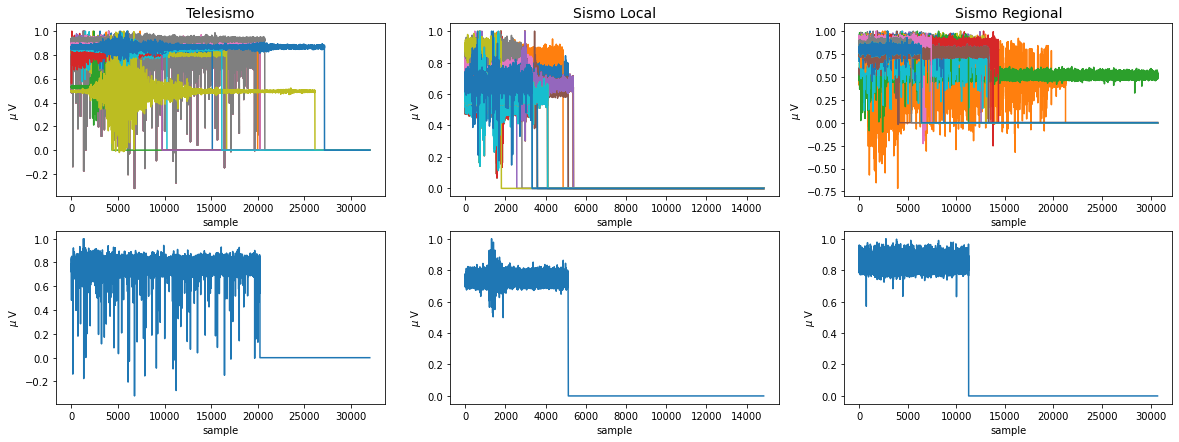

In [6]:
data = sc.loadmat('/content/gdrive/MyDrive/MiniProyecto1/sisTele.mat')
data.keys() # variables del diccionario
TeleSignal = data['Y']
fs = data['fs']
plt.figure()
plt.figure(figsize=(20,7))
plt.subplot(2, 3, 1)
plt.plot(TeleSignal.T)
plt.title("Telesismo", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

data = sc.loadmat('/content/gdrive/MyDrive/MiniProyecto1/sisLoc.mat')
data.keys() # variables del diccionario
LocSignal = data['Y']
plt.subplot(2, 3, 2)
plt.plot(LocSignal.T)
plt.title("Sismo Local", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

data = sc.loadmat('/content/gdrive/MyDrive/MiniProyecto1/sisReg.mat')
data.keys() # variables del diccionario
RegSignal = data['Y']
plt.subplot(2, 3, 3)
plt.plot(RegSignal.T)
plt.title("Sismo Regional", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

idSignal = 0 #Identificador de la señal seleccionada (de las 21).
plt.subplot(2, 3, 4)
plt.plot(TeleSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

plt.subplot(2, 3, 5)
plt.plot(LocSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

plt.subplot(2, 3, 6)
plt.plot(RegSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')


<Figure size 432x288 with 0 Axes>

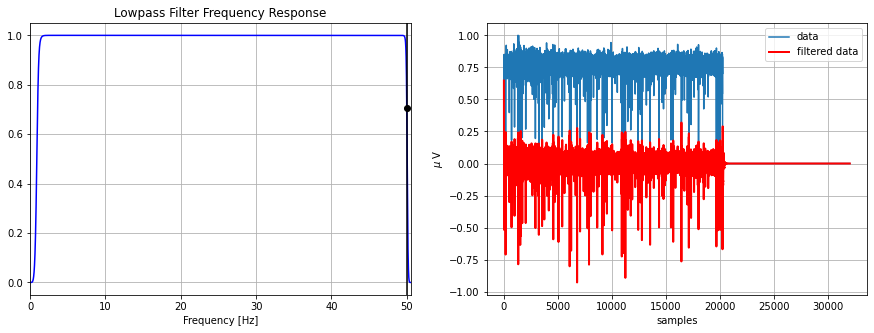

In [7]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 101.0      # sample rate, Hz
cutoff1 = 1
cutoff = 50  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
#b, a = butter_lowpass(cutoff, fs, order)
b, a = butter_bandpass(cutoff1, cutoff, fs, order=5)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.figure()
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

data = TeleSignal[0,:]

# Filter the data, and plot both the original and filtered signals.
#y = butter_lowpass_filter(data, cutoff, fs, order)
y = butter_bandpass_filter(data, cutoff1, cutoff, fs, order=5)

plt.subplot(1, 2, 2)
plt.plot(data, label='data')
plt.plot(y, 'r-', linewidth=2, label='filtered data')
plt.xlabel('samples')
plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

<Figure size 432x288 with 0 Axes>

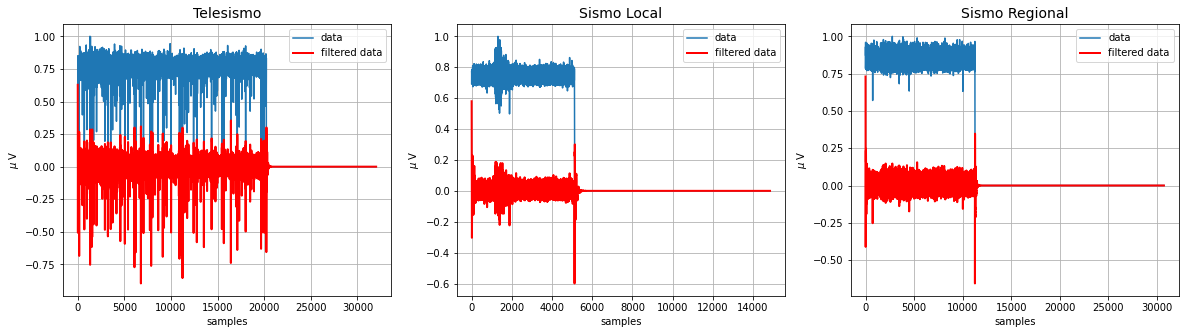

In [8]:
#Requisitos del filtro.
order = 6 #Orden del filtro.
fs = 101.0 #Frecuencia de muestreo, Hz.
cutoff1 = 50 #Highcut, Hz.
cutoff2 = 1 #Lowcut, Hz.

#Generamos matrices para almacenar las señales filtradas.
TeleSignalFiltered = np.zeros( (21, 32000) )
LocSignalFiltered = np.zeros( (21, 14848) )
RegSignalFiltered = np.zeros( (21, 30720) )

#Filtramos las señales.
for i in range(0, 21):
  #TeleSignalFiltered[i,:] = butter_lowpass_filter(TeleSignal[i,:], cutoff1, fs, order)
  #LocSignalFiltered[i,:] = butter_lowpass_filter(LocSignal[i,:], cutoff1, fs, order)
  #RegSignalFiltered[i,:] = butter_lowpass_filter(RegSignal[i,:], cutoff1, fs, order)
  TeleSignalFiltered[i,:] = butter_bandpass_filter(TeleSignal[i,:], cutoff2, cutoff1, fs, order)
  LocSignalFiltered[i,:] = butter_bandpass_filter(LocSignal[i,:], cutoff2, cutoff1, fs, order)
  RegSignalFiltered[i,:] = butter_bandpass_filter(RegSignal[i,:], cutoff2, cutoff1, fs, order)

#Graficamos la señal origilan y la señal filtrada.
idSignal = 0 #Identificador de la señal seleccionada (de las 21).
plt.figure()
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1), plt.plot(TeleSignal[idSignal,:], label='data');
plt.subplot(1, 3, 1), plt.plot(TeleSignalFiltered[idSignal,:], 'r-', linewidth=2, label='filtered data');
plt.title("Telesismo", fontsize=14), plt.xlabel('samples'), plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2), plt.plot(LocSignal[idSignal,:], label='data');
plt.subplot(1, 3, 2), plt.plot(LocSignalFiltered[idSignal,:], 'r-', linewidth=2, label='filtered data');
plt.title("Sismo Local", fontsize=14), plt.xlabel('samples'), plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3), plt.plot(RegSignal[idSignal,:], label='data');
plt.subplot(1, 3, 3), plt.plot(RegSignalFiltered[idSignal,:], 'r-', linewidth=2, label='filtered data');
plt.title("Sismo Regional", fontsize=14), plt.xlabel('samples'), plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

<Figure size 432x288 with 0 Axes>

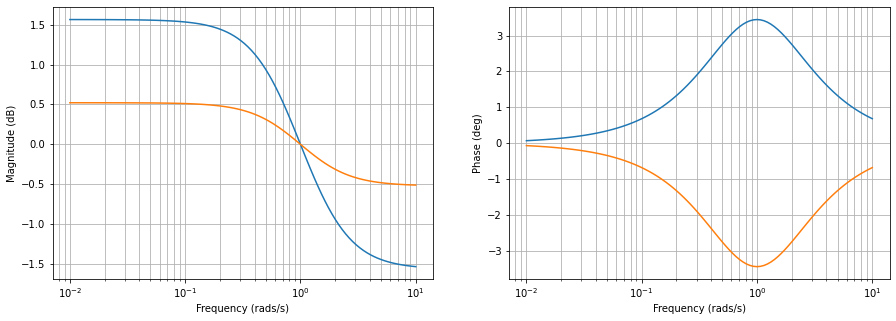

In [9]:
b, a = butter_bandpass(cutoff2, cutoff1, fs, order)
b1, a1 = butter_lowpass(cutoff1, fs, order)

sys = (b, a)
sys1 = (b1, a1)

w, mag, phase = bode(sys)
w1, mag1, phase1 = bode(sys1)

plt.figure()
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.semilogx(w, mag) # Bode magnitude plot. bandpass
plt.semilogx(w1, mag1) # Bode magnitude plot. lowpass
plt.xlabel('Frequency (rads/s)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which="both")

plt.subplot(1, 2, 2)
plt.semilogx(w, phase) # Bode phase plot. bandpass
plt.semilogx(w1, phase1) # Bode magnitude plot. lowpass
plt.xlabel('Frequency (rads/s)') 
plt.ylabel('Phase (deg)')
plt.grid(True, which="both")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

<Figure size 432x288 with 0 Axes>

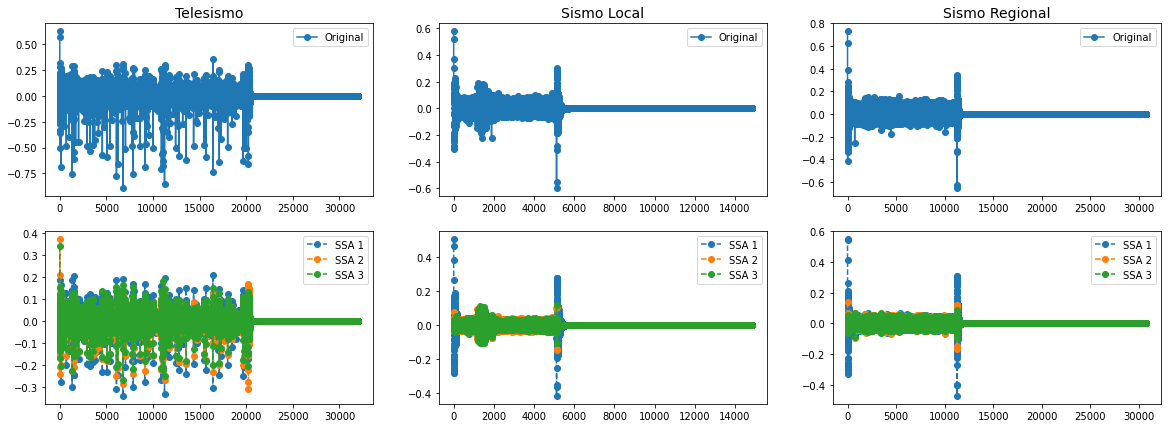

In [10]:
groups = 3 #Conjunto de señales subyacentes.
ssa = SingularSpectrumAnalysis(window_size=groups) #Singular Spectrum Analysis.

#Creamos las matrices con las nuevas señales subyacentes para cada conjunto de señales.
Tele_ssa = ssa.fit_transform(TeleSignalFiltered) 
Loc_ssa = ssa.fit_transform(LocSignalFiltered) 
Reg_ssa = ssa.fit_transform(RegSignalFiltered)

#Show the results for the first time series and its subseries.
idSignal = 0 # Identificador de la señal seleccionada (de las 21).
plt.figure()
plt.figure(figsize=(20,7))
plt.subplot(2, 3, 1), plt.plot(TeleSignalFiltered[idSignal], 'o-', label='Original'), plt.title("Telesismo", fontsize=14), plt.legend(loc='best')
plt.subplot(2, 3, 2), plt.plot(LocSignalFiltered[idSignal], 'o-', label='Original'), plt.title("Sismo Local", fontsize=14), plt.legend(loc='best')
plt.subplot(2, 3, 3), plt.plot(RegSignalFiltered[idSignal], 'o-', label='Original'), plt.title("Sismo Regional", fontsize=14), plt.legend(loc='best')

for i in range(groups):
    plt.subplot(2, 3, 4), plt.plot(Tele_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1)), plt.legend(loc='best')
    plt.subplot(2, 3, 5), plt.plot(Loc_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1)), plt.legend(loc='best')
    plt.subplot(2, 3, 6), plt.plot(Reg_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1)), plt.legend(loc='best')

# The first subseries consists of the trend of the original time series.
# The second and third subseries consist of noise.

In [11]:
#plt.subplot(3,1,1),plt.plot(X_ssa[idSignal, 0])
#plt.subplot(3,1,2),plt.plot(X_ssa[idSignal, 1])
#plt.subplot(3,1,3),plt.plot(X_ssa[idSignal, 2])

In [12]:
#testsig=Tele_ssa[0,1]; plt.figure(figsize=(20, 6))
#plt.subplot(1,3,1); plt.plot(testsig);
#f, t, Zxx = stft(testsig, fs)
#plt.subplot(1,3,2); plt.plot(Zxx);
#fr = np.fft.fft(testsig)
#plt.subplot(1,3,3); plt.plot(fr);


<Figure size 432x288 with 0 Axes>

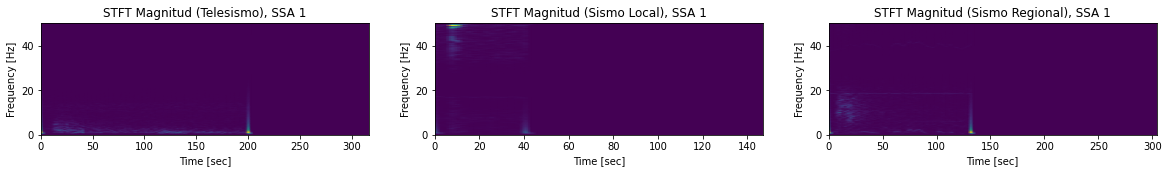

<Figure size 432x288 with 0 Axes>

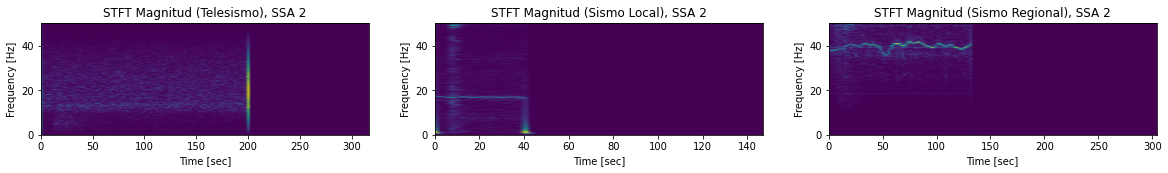

<Figure size 432x288 with 0 Axes>

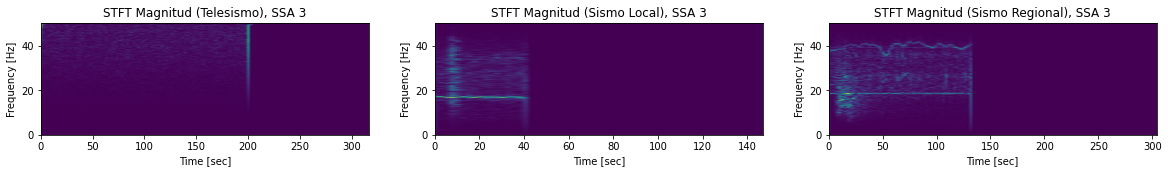

In [13]:
aux=[0,3,6]
idSignal = 15 # Identificador de la señal seleccionada (de las 21).

# Calculemos la STFT
from scipy import signal
for i in range(0, 3):
  Tele_f, Tele_t, Tele_Zxx = signal.stft(Tele_ssa[idSignal,i], fs, nperseg=512)
  Tele_absZxx = np.abs(Tele_Zxx)
  Loc_f, Loc_t, Loc_Zxx = signal.stft(Loc_ssa[idSignal,i], fs, nperseg=512)
  Loc_absZxx = np.abs(Loc_Zxx)
  Reg_f, Reg_t, Reg_Zxx = signal.stft(Reg_ssa[idSignal,i], fs, nperseg=512)
  Reg_absZxx = np.abs(Reg_Zxx)

  plt.figure()
  plt.figure(figsize=(20,7))
  plt.subplot(3, 3, 1+aux[i]), plt.pcolormesh(Tele_t, Tele_f, Tele_absZxx, shading='gouraud') 
  plt.title('STFT Magnitud (Telesismo), SSA {0}'.format(i + 1)), plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
  plt.subplot(3, 3, 2+aux[i]), plt.pcolormesh(Loc_t, Loc_f, Loc_absZxx, shading='gouraud')
  plt.title('STFT Magnitud (Sismo Local), SSA {0}'.format(i + 1)), plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
  plt.subplot(3, 3, 3+aux[i]), plt.pcolormesh(Reg_t, Reg_f, Reg_absZxx, shading='gouraud')
  plt.title('STFT Magnitud (Sismo Regional), SSA {0}'.format(i + 1)), plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')

A partir de lo anterior podemos analizar que el espectrograma de la STFT va a permitirnos analizar los cambios de señales no estacionarias.

"En la práctica, el procedimiento para calcular la STFT es dividir una señal de tiempo en segmentos más cortos de igual longitud y luego calcular la transformada de Fourier por separado en cada segmento más corto."

In [34]:
# Dado que en Zxx queda el espectro para cada uno de estos segmentos analizaremos las características de estos
# En cada Fila de Zxx tendremos la FFT de cada segmento
# Asi que:
Tele_f, Tele_t, Tele_Zxx = signal.stft(Tele_ssa[0,0], fs, nperseg=512)
Tele_absZxx = np.abs(Tele_Zxx)
MaxSpectro = np.max(Tele_absZxx)
idFrecMax = np.where(Tele_absZxx==MaxSpectro) # Posición i, j de la matriz absZxx donde i: frec, j: time
frecPMax = np.squeeze(Tele_f[idFrecMax[0]])
print('max(|Zxx| = ',MaxSpectro,'dB\nFmax at maxPower: ',frecPMax,'Hz')

max(|Zxx| =  0.013380374775649071 dB
Fmax at maxPower:  22.8828125 Hz


In [41]:
def extract_features(Zxx, f):

  # En la matriz Zxx se tiene una matriz de #defrecs * #times
  # Zxx[i,j], sería el espectro en la frecuencia[i] y el tiempo [j]  
  absZxx = np.abs(Zxx)
  maxP = np.max(absZxx)
  id = np.where(absZxx==maxP)
  frecPmax = np.squeeze(f[id[0]])
  
  maxF = np.max(absZxx,axis=1)
  #idx_Pot_ord = idx_Pot_ord[-4:]
  #print('Pmax at: ',maximos[idx_Pot_ord],' dB\nfPmax: ',f[idx_Pot_ord])
  meanP = np.mean(maxF)
  varP = np.var(maxF)
  maxSpectrum = np.max(maxF)
  minSpectrum = np.min(maxF)

  dataRow = np.random.rand(6)
  dataRow[0]=maxP
  dataRow[1]=frecPmax
  dataRow[2]=meanP 
  dataRow[3]=varP 
  dataRow[4]=maxSpectrum 
  dataRow[5]=minSpectrum 
  return dataRow

In [91]:
Tele_f, Tele_t, Tele_Zxx = signal.stft(Tele_ssa[0,0], fs, nperseg=512)
dataRow = extract_features(Tele_Zxx, Tele_f)
print('Potencia máxima: ',dataRow[0],' dB')
print('Frecuencia en la potencia máxima: ',dataRow[1],' Hz')
print('Media: ',dataRow[2])
print('Varianza: ',dataRow[3])
print('Máximo del espectro: ',dataRow[4],' dB')
print('Mínimo del espectro: ',dataRow[5],' dB')

#dataMatrixFinal = []
TeleMatrix = np.zeros( (21,18) )
LocMatrix = np.zeros( (21,18) )
RegMatrix = np.zeros( (21,18) )

for idSignal in range(0, 21):

  dataRowTele = np.zeros( (0, 0) )
  dataRowLoc = np.zeros( (0, 0) )
  dataRowReg = np.zeros( (0, 0) )

  for i in range(0, 3):
    Tele_f, Tele_t, Tele_Zxx = signal.stft(Tele_ssa[idSignal,i], fs, nperseg=512)
    featuresTele = extract_features(Tele_Zxx, Tele_f)
    dataRowTele = np.append(dataRowTele, featuresTele)

    Loc_f, Loc_t, Loc_Zxx = signal.stft(Loc_ssa[idSignal,i], fs, nperseg=512)
    featuresLoc = extract_features(Loc_Zxx, Loc_f)
    dataRowLoc = np.append(dataRowLoc, featuresLoc)

    Reg_f, Reg_t, Reg_Zxx = signal.stft(Reg_ssa[idSignal,i], fs, nperseg=512)
    featuresReg = extract_features(Reg_Zxx, Reg_f)
    dataRowReg = np.append(dataRowReg, featuresReg)
  
  TeleMatrix[idSignal:]= dataRowTele
  LocMatrix[idSignal:] = dataRowLoc
  RegMatrix[idSignal:] = dataRowReg

dataSet_X = np.concatenate((TeleMatrix,LocMatrix,RegMatrix),axis = 0)

#print(dataRowTele)
#print(dataRowLoc)
#print(dataRowReg)

#print(dataMatrixRow)


Potencia máxima:  0.013380374775649071  dB
Frecuencia en la potencia máxima:  22.8828125  Hz
Media:  0.0028460968271885275
Varianza:  4.911760403903875e-06
Máximo del espectro:  0.013380374775649071  dB
Mínimo del espectro:  0.0003061578901033913  dB


## DataFrames en PANDAS

In [92]:
import pandas as pd

d = {"one": pd.Series([1.0, 2.0, 3.0], index=["a", "b", "c"]),
       "two": pd.Series([1.0, 2.0, 3.0, 4.0], index=["a", "b", "c", "d"]),
     }
 

#df = pd.DataFrame(d)

In [93]:
#df

In [62]:
import seaborn as sns

#penguins = sns.load_dataset("penguins")

In [95]:
#penguins

In [96]:
#sns.pairplot(penguins, hue="island")

## Numpy Array to DataFrame

In [97]:
X = dataSet_X
print(X)

[[1.33803748e-02 2.28828125e+01 2.84609683e-03 ... 6.56155254e-06
  1.36460591e-02 2.91460478e-05]
 [1.33803748e-02 2.28828125e+01 2.84609683e-03 ... 6.56155254e-06
  1.36460591e-02 2.91460478e-05]
 [1.33803748e-02 2.28828125e+01 2.84609683e-03 ... 6.56155254e-06
  1.36460591e-02 2.91460478e-05]
 ...
 [3.28892395e-02 1.38085938e+00 3.70220217e-03 ... 3.44066281e-07
  3.72345397e-03 2.13277945e-04]
 [3.28892395e-02 1.38085938e+00 3.70220217e-03 ... 3.44066281e-07
  3.72345397e-03 2.13277945e-04]
 [3.28892395e-02 1.38085938e+00 3.70220217e-03 ... 3.44066281e-07
  3.72345397e-03 2.13277945e-04]]


In [98]:
# Dataframe de un nparray
df = pd.DataFrame(X,columns=['Pot(SSA1)','F_Pmax(SSA1)','Media(SSA1)','Var(SSA1)','Max(SSA1)','Min(SSA1)', 
                             'Pot(SSA2)','F_Pmax(SSA2)','Media(SSA2)','Var(SSA2)','Max(SSA2)','Min(SSA2)',
                             'Pot(SSA3)','F_Pmax(SSA3)','Media(SSA3)','Var(SSA3)','Max(SSA3)','Min(SSA3)'])

In [99]:
df

,Pot(SSA1),F_Pmax(SSA1),Media(SSA1),Var(SSA1),Max(SSA1),Min(SSA1),Pot(SSA2),F_Pmax(SSA2),Media(SSA2),Var(SSA2),Max(SSA2),Min(SSA2),Pot(SSA3),F_Pmax(SSA3),Media(SSA3),Var(SSA3),Max(SSA3),Min(SSA3)
0,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
1,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
2,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
3,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
4,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.036245,1.380859,0.004065,0.000034,0.036245,0.000221,0.004788,24.658203,0.001369,6.639490e-07,0.004788,0.000264,0.006026,38.466797,0.001036,1.335983e-06,0.006026,0.000015
59,0.034564,1.380859,0.003953,0.000031,0.034564,0.000186,0.006359,49.513672,0.001067,1.619926e-06,0.006359,0.000016,0.003872,17.162109,0.001213,4.200849e-07,0.003872,0.000226
60,0.032889,1.380859,0.003702,0.000027,0.032889,0.000144,0.009995,49.908203,0.001128,2.104844e-06,0.009995,0.000056,0.003723,16.767578,0.001126,3.440663e-07,0.003723,0.000213
61,0.032889,1.380859,0.003702,0.000027,0.032889,0.000144,0.009995,49.908203,0.001128,2.104844e-06,0.009995,0.000056,0.003723,16.767578,0.001126,3.440663e-07,0.003723,0.000213


In [104]:
Etiquetas = np.zeros((63,1))
Etiquetas[0:21] = 0
Etiquetas[21:42] = 1
Etiquetas[42:] = 2

print(Etiquetas)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]]


In [73]:
df['Etiquetas'] = Etiquetas

In [106]:
df

,Pot(SSA1),F_Pmax(SSA1),Media(SSA1),Var(SSA1),Max(SSA1),Min(SSA1),Pot(SSA2),F_Pmax(SSA2),Media(SSA2),Var(SSA2),Max(SSA2),Min(SSA2),Pot(SSA3),F_Pmax(SSA3),Media(SSA3),Var(SSA3),Max(SSA3),Min(SSA3)
0,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
1,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
2,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
3,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
4,0.013380,22.882812,0.002846,0.000005,0.013380,0.000306,0.018768,1.183594,0.003095,7.820541e-06,0.018768,0.000598,0.013646,1.183594,0.003142,6.561553e-06,0.013646,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.036245,1.380859,0.004065,0.000034,0.036245,0.000221,0.004788,24.658203,0.001369,6.639490e-07,0.004788,0.000264,0.006026,38.466797,0.001036,1.335983e-06,0.006026,0.000015
59,0.034564,1.380859,0.003953,0.000031,0.034564,0.000186,0.006359,49.513672,0.001067,1.619926e-06,0.006359,0.000016,0.003872,17.162109,0.001213,4.200849e-07,0.003872,0.000226
60,0.032889,1.380859,0.003702,0.000027,0.032889,0.000144,0.009995,49.908203,0.001128,2.104844e-06,0.009995,0.000056,0.003723,16.767578,0.001126,3.440663e-07,0.003723,0.000213
61,0.032889,1.380859,0.003702,0.000027,0.032889,0.000144,0.009995,49.908203,0.001128,2.104844e-06,0.009995,0.000056,0.003723,16.767578,0.001126,3.440663e-07,0.003723,0.000213


In [105]:
#sns.pairplot(df, hue="Etiquetas")